In [81]:
from importlib import import_module
import argparse
import numpy as np
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Use Jupyter 
def load_model(model_name, model_dir):
    model_cls = getattr(import_module("model.models"),model_name)
    model = model_cls(
        num_classes=18
    )
    state_dict = torch.load(model_dir)
    for key in list(state_dict.keys()):
        state_dict[key.replace("res50.", "model.")] = state_dict.pop(key)
    model.load_state_dict(state_dict)
    
    return model

def load_dataset(dataset, data_dir):
    dataset_module = getattr(import_module("dataset.mask_base_dataset"), dataset)  
    dataset = dataset_module(
        data_dir= data_dir
    )
    transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])
    dataset.set_transform(transform)
    
    return dataset

def grad_cam(args, start_idx = 0, wrong_only = False, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) :

    # resnet50 target_layer == layer4
    model = load_model(args.model, args.model_dir)
    model.eval()
    dataset = load_dataset(args.dataset, args.data_dir)
    
    cam = GradCAM(model=model, target_layer=model.model.layer4, use_cuda=True)
    

    fig, axes = plt.subplots(1,5,figsize=(20,5))
    idx = 0
    curr_idx = start_idx
    while True:
        
        inputs, label = dataset[curr_idx]
        curr_idx += 1

        if label != args.target_label : continue

        output = model(inputs.unsqueeze(0).to('cuda'))
        _ , pred = output.max(dim=-1)

        if wrong_only and str(label) == str(pred.item()):
            continue

        img = inputs.clone()
        for c,(m,s) in enumerate(zip(mean,std)) :
            img[c,:,:] = img[c,:,:] * s + m
        img = transforms.ToPILImage()(img)

        grayscale_cam = cam(input_tensor=inputs.unsqueeze(0).detach(), target_category=None)
        grayscale_cam = grayscale_cam[0, :]
        img = show_cam_on_image(np.float32(img) / 255, grayscale_cam, use_rgb=True)

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title("Label : {} Pred : {}".format(label,pred.item()))
        idx += 1
        if idx == 5 : break
        

In [84]:
import argparse

args = argparse.Namespace(
    dataset="MaskBaseDataset",
    model="Customresnet50",
    data_dir="/opt/ml/input/data/train/images",
    model_dir="pretrained/best.pth",
    target_label=0
)

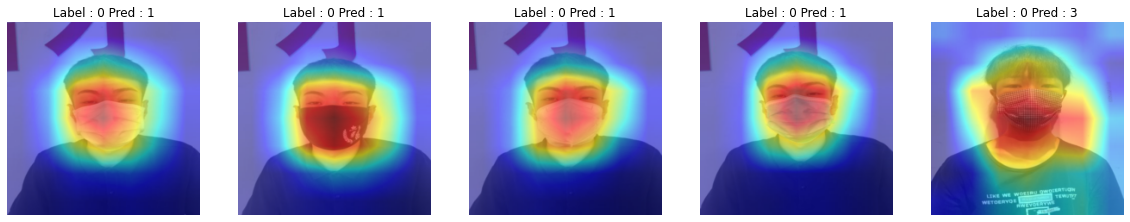

In [87]:
grad_cam(args, 1200, wrong_only=True)